# Gérer le déséquilibre des classes

### Importation des librairies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
import seaborn as sn
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D

## 1) Mise en évidence du déséquilibre

### 1.1) Chargement des données

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'third_steps',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(45,45)
)

Found 294182 files belonging to 32 classes.


### 1.2) Observation de la répartition des classes

On récupère tout les labels de notre dataset dans une liste.

In [3]:
all_labels = []
for image, label in dataset:
    # Convertir les labels en numpy array
    labels = np.array(label)
    # Étendre la liste avec les nouveaux labels
    all_labels.extend(labels)

On mets tout dans un data frame, et à l'aide des fonctions d'aggregation .count() et .groupby(), on compte le nombre d'éléments par classe.

In [4]:
classes_train_ds = pd.DataFrame(all_labels, columns=['label']) # On créé un dataframe
classes_train_ds['count'] = classes_train_ds['label'] #on copie dans une colonne count la colonne label
dist_classes = classes_train_ds.groupby('label').count() # on compte le nombre d'éléments par classe
dist_classes['labels'] = dataset.class_names #On récupère le nom des classes 
dist_classes.head(32)

,count,labels
label,,
0,14294,(
1,14355,)
2,25112,+
3,33997,-
4,6914,0
5,26520,1
6,26141,2
7,10909,3
8,7396,4


Ce qui donne graphiquement :

<Axes: xlabel='labels', ylabel='count'>

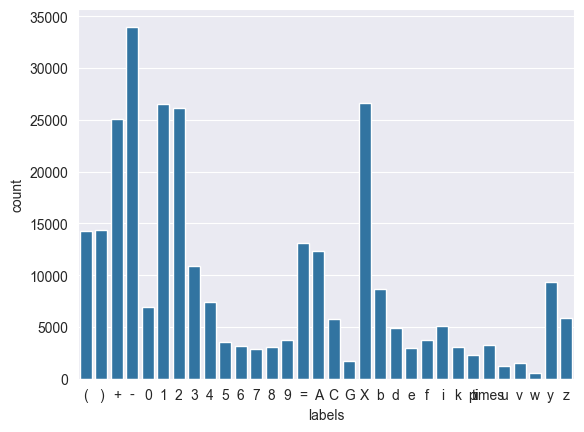

In [5]:
sn.barplot(x='labels', y='count',data=dist_classes)

In [6]:
dist_classes.describe()

,count
count,32.000000
mean,9193.187500
std,9019.947884
min,556.000000
25%,3072.500000
50%,5471.000000
75%,12551.250000
max,33997.000000


On observe effectivement un fort déséquilibre du nombre d'éléments dans nos classes. Nous allons donc tester plusieurs approches pour gérer ce déséquilibre.

## 2) Approche du ré-équilibrage par rejet

Cette méthode consiste à supprimer des éléments des classes majoritaires pour atteindre un équilibre. Pour faire cela nous nous sommes appuyés sur un exemple dans la documentation de tensorflow : https://www.tensorflow.org/guide/data?hl=fr#resampling

### 2.1) Création d'un dataset équilibré sans w

In [ ]:
dataset_sans_w = tf.keras.utils.image_dataset_from_directory(
    'third_steps - Copie',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(45,45)
)

In [ ]:
def class_func(images, labels):
    return labels

resample_ds = (
    dataset_sans_w
    .unbatch()
    .rejection_resample(class_func, target_dist = [1/31]*31, initial_dist=None)
)

In [ ]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)
balanced_ds

In [ ]:
data = []
labels = []
all_balanced_labels =[]


for features, label in balanced_ds:
    data.append(features)
    labels.append(tf.one_hot(label, depth=31))
    all_balanced_labels.append(label)


In [ ]:
balanced_ds = tf.data.Dataset.from_tensor_slices((data, labels))

In [ ]:
all_balanced_labels = np.array(all_balanced_labels)

In [ ]:
classes_balanced_ds = pd.DataFrame(all_balanced_labels, columns=['label'])  # On créé un dataframe
classes_balanced_ds['count'] = classes_balanced_ds['label']  #on copie dans une colonne count la colonne label
dist_balanced_classes = classes_balanced_ds.groupby('label').count()  # on compte le nombre d'éléments par classe
dist_balanced_classes['labels'] = dataset_sans_w.class_names  #On récupère le nom des classes 
dist_balanced_classes

In [ ]:
sn.barplot(x='labels', y='count', data = dist_balanced_classes)

In [ ]:
# Configuration de l'ensemble de données pour l'entraînement
balanced_ds = balanced_ds.shuffle(buffer_size=len(data), seed=123)
balanced_ds = balanced_ds.batch(32)
balanced_ds = balanced_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Afficher un échantillon d'images et d'étiquettes de l'ensemble de données
for images, labels in balanced_ds.take(1):
    print("Forme des images :", images.shape)
    print("Forme des étiquettes :", labels.shape)
    print("type des étiquettes :", type(labels))

division du dataset en train et validation

In [ ]:

# Définir la taille de l'ensemble de validation
validation_size = int(0.2 * len(balanced_ds))

# Diviser l'ensemble de données en ensembles d'entraînement et de validation
train_ds = balanced_ds.skip(validation_size)
val_ds = balanced_ds.take(validation_size)

# Afficher le nombre d'exemples dans chaque ensemble
print("Nombre d'exemples dans l'ensemble d'entraînement :", len(train_ds))
print("Nombre d'exemples dans l'ensemble de validation :", len(val_ds))

#### 2.1.1) Entrainement d'Albert

In [ ]:
Albert_rejet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(45, 45, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(45, 45, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(31, activation='softmax')
])

In [ ]:
Albert_rejet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
Albert_rejet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
Albert_rejet.save('Albert_rejet.keras')

#### 2.1.2) Entrainemment d'Alain

Il faut considérer les images en couleurs

In [ ]:
dataset_sans_w_rgb = tf.keras.utils.image_dataset_from_directory(
    'third_steps - Copie',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    image_size=(45,45)
)

In [ ]:
def class_func(images, labels):
    return labels

resample_ds_rgb = (
    dataset_sans_w_rgb
    .unbatch()
    .rejection_resample(class_func, target_dist = [1/31]*31, initial_dist=None)
)


In [ ]:
balanced_ds_rgb = resample_ds_rgb.map(lambda extra_label, features_and_label: features_and_label)
balanced_ds_rgb

In [ ]:
data = []
labels = []

for features, label in balanced_ds_rgb:
    data.append(features)
    labels.append(tf.one_hot(label, depth=31))


In [ ]:
balanced_ds_rgb = tf.data.Dataset.from_tensor_slices((data, labels))

In [ ]:
balanced_ds_rgb = balanced_ds_rgb.shuffle(buffer_size=len(data), seed=123)
balanced_ds_rgb = balanced_ds_rgb.batch(32)
balanced_ds_rgb = balanced_ds_rgb.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Définir la taille de l'ensemble de validation
validation_size = int(0.2 * len(balanced_ds_rgb))

# Diviser l'ensemble de données en ensembles d'entraînement et de validation
train_ds_rgb = balanced_ds_rgb.skip(validation_size)
val_ds_rgb = balanced_ds_rgb.take(validation_size)


On peut maintenant créer Alain

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dropout

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
normalized_ds = train_ds_rgb.map(lambda x, y: (preprocess_input(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[-1,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE
train_ds_rgb = train_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_rgb = val_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
input_shape = (45, 45, 3)  # Taille des images redimensionnées (45x45 en couleur)
num_classes = 32  # Nombre de classes pour les symboles mathématiques
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
input_tensor = Input(shape=(45, 45, 3))
x = input_tensor
x = preprocess_input(x)
# followed by image-net model 
x = base_model(x, training=False)

y = GlobalAveragePooling2D()(x)
y = Dense(128, activation='relu')(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.2)(y)
y = Dense(31, activation='softmax')(y)
Alain = tf.keras.Model(input_tensor, y)

In [ ]:
Alain.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
base_model.trainable = False

In [ ]:
Alain.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10
)

In [ ]:
Alain.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10
)

In [ ]:
filename = 'Alain_eq_rej_20epochs_drop02.keras'
Alain.save(filename)

## 3) Approche pondération des classes

In [7]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(all_labels),
                                                  y=all_labels)

In [8]:
classes_w = pd.DataFrame(class_weights, columns=['weight']) # On créé un dataframe
classes_w['labels'] = dataset.class_names #On récupère le nom des classes 
classes_w.head(32)

,weight,labels
0,0.643150,(
1,0.640417,)
2,0.366087,+
3,0.270412,-
4,1.329648,0
5,0.346651,1
6,0.351677,2
7,0.842716,3
8,1.242995,4
9,2.593283,5


<Axes: xlabel='labels', ylabel='weight'>

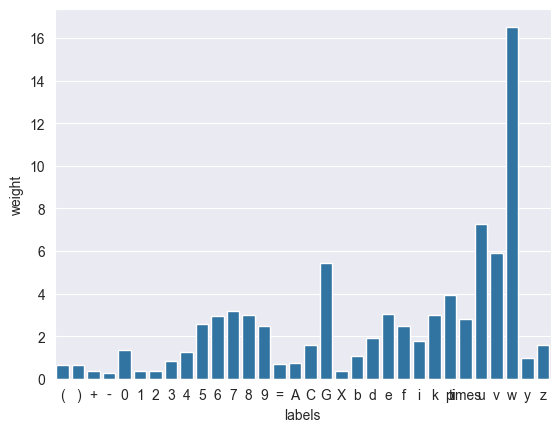

In [9]:
sn.barplot(x='labels', y='weight', data=classes_w)

In [10]:
classes_w['count'] = dist_classes['count']
classes_w['weighted_count'] = classes_w['count'] * classes_w['weight']
classes_w

,weight,labels,count,weighted_count
0,0.643150,(,14294,9193.1875
1,0.640417,),14355,9193.1875
2,0.366087,+,25112,9193.1875
3,0.270412,-,33997,9193.1875
4,1.329648,0,6914,9193.1875
5,0.346651,1,26520,9193.1875
6,0.351677,2,26141,9193.1875
7,0.842716,3,10909,9193.1875
8,1.242995,4,7396,9193.1875
9,2.593283,5,3545,9193.1875


<Axes: xlabel='labels', ylabel='weighted_count'>

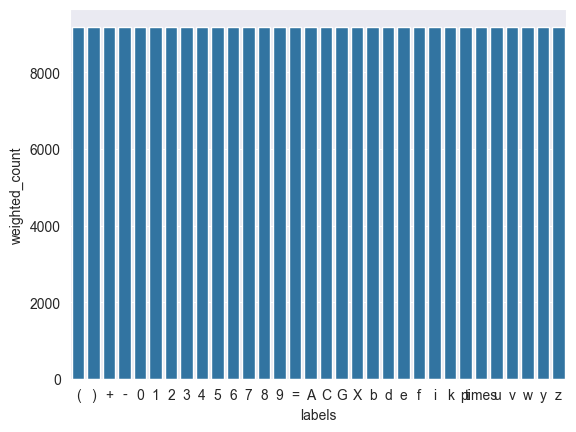

In [35]:
sn.barplot(x = 'labels', y = 'weighted_count', data = classes_w)

In [11]:
class_weights_dict = dict(enumerate(class_weights))

### 3.1) Entrainement d'Albert

On commence par charger les données 

In [ ]:
#donnees d entrainement
train_ds = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/arthu/OneDrive/Documents/extracted_images/third_steps',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(45, 45),
    batch_size=64,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

# donnees de test
val_ds = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/arthu/OneDrive/Documents/extracted_images/third_steps',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(45, 45),
    batch_size=64,
    shuffle= True,
    seed=123,
    validation_split=0.2,
    subset="validation"

)

In [ ]:
#classes pour les donnees d entrainement
class_names = train_ds.class_names
#normalisation des donnees
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

#optimisation de la lecture des donnees
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

On a toujours le même modèle

In [ ]:
Albert_pond = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(45, 45, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(45, 45, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='softmax')
])

In [ ]:
Albert_pond.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Lors de l'entraînement, on spécifie class_weight  

In [ ]:
Albert_pond.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    epochs=10
)

In [ ]:
Albert_pond.save('Albert_pond.keras')

### 3.2) Entrainement d'Alain

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/arthu/OneDrive/Documents/extracted_images/third_steps',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(45,45),
    batch_size= 64,
    shuffle= True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 294182 files belonging to 32 classes.
Using 235346 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/arthu/OneDrive/Documents/extracted_images/third_steps',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(45,45),
    batch_size= 64,
    shuffle= True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 294182 files belonging to 32 classes.
Using 58836 files for validation.


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
normalized_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[-1,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1.0 1.0


In [15]:
input_shape = (45, 45, 3)  # Taille des images redimensionnées (45x45 en couleur)
num_classes = 32  # Nombre de classes pour les symboles mathématiques
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
input_tensor = Input(shape=(45, 45, 3))
x = input_tensor
x = preprocess_input(x)
# followed by image-net model 
x = base_model(x, training=False)

y = tf.keras.layers.GlobalAveragePooling2D()(x)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dropout(0.05)(y)
y = tf.keras.layers.Dense(32, activation='softmax')(y)
Al1 = tf.keras.Model(input_tensor, y)

In [19]:
Al1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [20]:
base_model.trainable = False

In [21]:
Al1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45, 45, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 45, 45, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 45, 45, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
Al1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight = class_weights_dict
)

Epoch 1/10
2323/3678 [=================>............] - ETA: 3:55 - loss: 3.4605 - accuracy: 0.0243